# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
# import libraries
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand, countDistinct
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC
from pyspark.ml.feature import StandardScaler, VectorAssembler,StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [3]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_capstone').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
df = spark.read.json('mini_sparkify_event_data.json')
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.count()

286500

In [7]:
df.describe('userId').show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            286500|
|   mean| 59682.02278593872|
| stddev|109091.94999910535|
|    min|                  |
|    max|                99|
+-------+------------------+



seems userId has null value

In [8]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630799|
|    min|                1|
|    max|             2474|
+-------+-----------------+



## Clean

In [9]:
# clean null and ' ' values
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_clean = df_clean.filter(df_clean["userId"] != "")
df_clean.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
df_clean.groupby("auth").agg(countDistinct("userId").alias("distinct_user_count")).show()

+---------+-------------------+
|     auth|distinct_user_count|
+---------+-------------------+
|Cancelled|                 52|
|Logged In|                225|
+---------+-------------------+



In [11]:
# the dataset is inbalanced

In [12]:
# indicate the churn users
df_churn = df_clean.filter(df_clean.auth=="Cancelled").select("userId").dropDuplicates()
churn_user_list = df_churn.select('userId').distinct().rdd.flatMap(lambda x: x).collect()

In [13]:
# add the indicator
df_indicate = df_clean.withColumn("churn", df_clean.userId.isin(churn_user_list))
df_indicate.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=False)]

In [14]:
df_indicate.dropDuplicates(['userId']).select('churn').groupby('churn').count().collect()

[Row(churn=True, count=52), Row(churn=False, count=173)]

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Gender

In [15]:
df_indicate.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     M|   89|
|false|     F|   84|
| true|     F|   20|
| true|     M|   32|
+-----+------+-----+



In [16]:
# Number of successes (positive outcomes) in each group
# Total number of observations (trials) in each group
count = [32,20]
nobs = [32+89,20+84]

stat, pval = proportions_ztest(count, nobs)

# Print the results
print("Z-statistic:", stat)
print("P-value:", pval)

Z-statistic: 1.28009744097
P-value: 0.200510868556


the p-value is more than the significance level, we cannot reject the null hypothesis and therefore we cannot say there is a significant difference in proportions between the groups.--basically, no significant difference

## Level

In [17]:
df_indicate.dropDuplicates(["userId"]).groupby(["churn", "level"]).count().sort("churn").show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|false| paid|   40|
|false| free|  133|
| true| paid|    8|
| true| free|   44|
+-----+-----+-----+



In [18]:
# Number of successes (positive outcomes) in each group
# Total number of observations (trials) in each group
count = [44,8]
nobs = [44+133,8+40]

stat, pval = proportions_ztest(count, nobs)

# Print the results
print("Z-statistic:", stat)
print("P-value:", pval)

Z-statistic: 1.19417650796
P-value: 0.232408930456


the p-value is more than the significance level, we cannot reject the null hypothesis and therefore we cannot say there is a significant difference in proportions between the groups.--basically, no significant difference

## State

In [19]:
split_city_state = split(df_indicate['location'], ',')
df_indicate = df_indicate.withColumn('city',split_city_state.getItem(0))
df_indicate = df_indicate.withColumn('state',split_city_state.getItem(1))

In [20]:
by_state = df_indicate.dropDuplicates(["userId"]).groupby(["state","churn"]).count().sort("state").toPandas()
by_state.head()

,state,churn,count
0,AK,False,2
1,AL,False,2
2,AL,True,2
3,AR,True,1
4,AZ,False,5


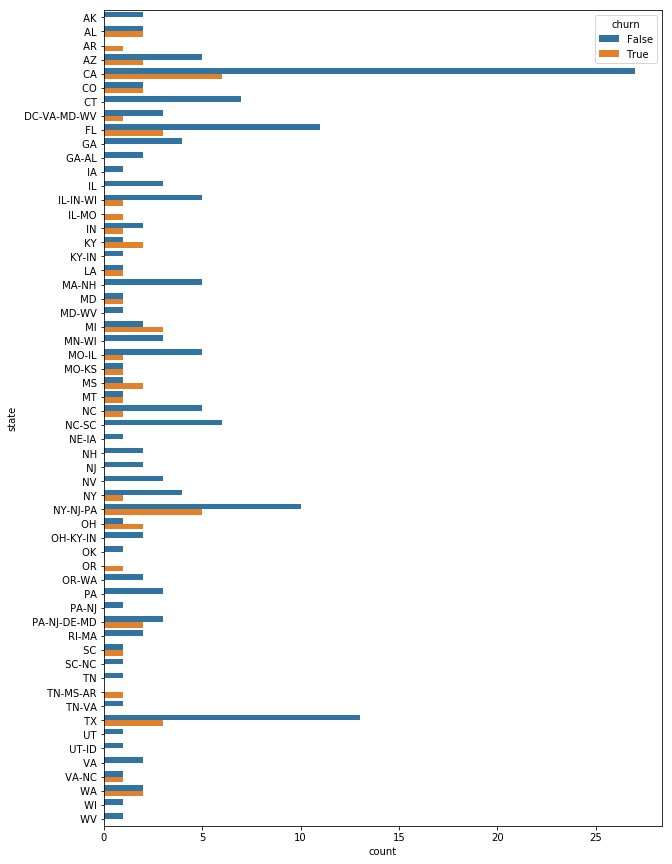

In [21]:
fig, ax = plt.subplots(figsize=(10,15))
sns.barplot( x="count",y="state", hue="churn", data=by_state,ax=ax);

Though there is some differences, there is no any clear trend

## Actions

In [22]:
df_indicate.select(["churn", "page"]).groupby(["churn", "page"]).count().sort("page").show()

+-----+--------------------+------+
|churn|                page| count|
+-----+--------------------+------+
| true|               About|    56|
|false|               About|   439|
|false|          Add Friend|  3641|
| true|          Add Friend|   636|
| true|     Add to Playlist|  1038|
|false|     Add to Playlist|  5488|
| true|              Cancel|    52|
| true|Cancellation Conf...|    52|
| true|           Downgrade|   337|
|false|           Downgrade|  1718|
| true|               Error|    32|
|false|               Error|   220|
|false|                Help|  1215|
| true|                Help|   239|
| true|                Home|  1672|
|false|                Home|  8410|
|false|              Logout|  2673|
| true|              Logout|   553|
|false|            NextSong|191714|
| true|            NextSong| 36394|
+-----+--------------------+------+
only showing top 20 rows



In [23]:
by_page = df_indicate.select(["page","churn"]).groupby([ "page","churn"]).count().sort("page").toPandas()
by_page.head()

,page,churn,count
0,About,True,56
1,About,False,439
2,Add Friend,True,636
3,Add Friend,False,3641
4,Add to Playlist,True,1038


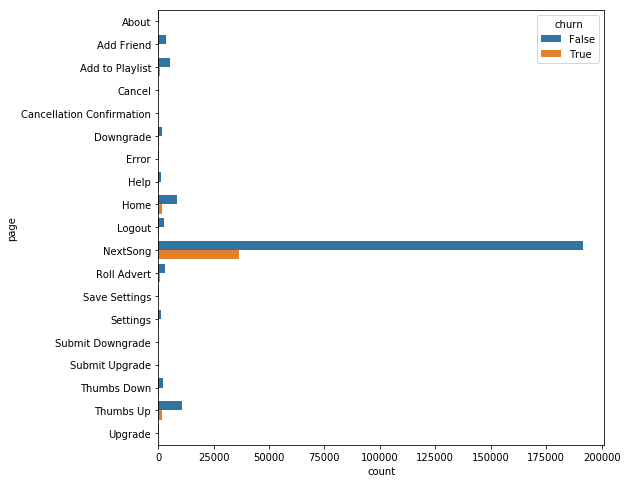

In [24]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="count",y="page", hue="churn", data=by_page,ax=ax);

Add Friend, Add to Playlist, Downgrade, Home, NextSong, Roll Advert, Thumbs Down,a nd Thumbs Up seem to have significant differences for the churn.  Home may be not useful. Add to Playlist and NextSong may both related to how many songs a user listened.  Thumbs Down and Thumbs Up seem cannot replace each other.  We may use all these: NextSong,ThumbsUp, ThumbsDown, AddtoPlaylist, AddFriend, RollAdvert.  Or, if we could count the number of unique songs and total songs of users, we may not need NextSong.

## Put things together

In [25]:
df_indicate

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, churn: boolean, city: string, state: string]

In [26]:
def get_numerical_metrics():
    '''
    join all numerical features together and implement Standscaler
    '''
    #page
    page_count = df_indicate.select(["userId","page"]).groupby(["userId","page"]).count()
    # create the pivot table
    page_pv = page_count.groupby('userId').pivot('page').agg(first('count')).fillna(0)
    # filter columns
    page_pv = page_pv.select(['userId','Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend', 'Roll Advert'])  
    
    #total songs number
    feature_ct_song = df_indicate.filter(df_indicate.page=='NextSong').select(["userId","song"]).\
                                             groupby(["userId"]).count()

    feature_ct_song = feature_ct_song.selectExpr("userId as userId","count as ct_song")
    
    #merge together
    result = page_pv.join(feature_ct_song,on='userId',how='inner')
    
    return result

In [27]:
numerical_feature = get_numerical_metrics()
numerical_feature

DataFrame[userId: string, Thumbs Up: bigint, Thumbs Down: bigint, Add to Playlist: bigint, Add Friend: bigint, Roll Advert: bigint, ct_song: bigint]

In [28]:
numerical_feature.show(2)

+------+---------+-----------+---------------+----------+-----------+-------+
|userId|Thumbs Up|Thumbs Down|Add to Playlist|Add Friend|Roll Advert|ct_song|
+------+---------+-----------+---------------+----------+-----------+-------+
|100010|       17|          5|              7|         4|         52|    275|
|200002|       21|          6|              8|         4|          7|    387|
+------+---------+-----------+---------------+----------+-----------+-------+
only showing top 2 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## Prepare Dataset

In [29]:
df_use = df_indicate.dropDuplicates(['userId']).sort('userId').select(['userId','churn'])
df_use = df_use.join(numerical_feature,'userId')
#fill NaN
df_use = df_use.na.fill(0)
for metric in df_use.columns[1:]:
    df_use = df_use.withColumn(metric,df_use[metric].cast('float'))
df_use.show()

+------+-----+---------+-----------+---------------+----------+-----------+-------+
|userId|churn|Thumbs Up|Thumbs Down|Add to Playlist|Add Friend|Roll Advert|ct_song|
+------+-----+---------+-----------+---------------+----------+-----------+-------+
|100010|  0.0|     17.0|        5.0|            7.0|       4.0|       52.0|  275.0|
|200002|  0.0|     21.0|        6.0|            8.0|       4.0|        7.0|  387.0|
|   125|  1.0|      0.0|        0.0|            0.0|       0.0|        1.0|    8.0|
|   124|  0.0|    171.0|       41.0|          118.0|      74.0|        4.0| 4079.0|
|    51|  1.0|    100.0|       21.0|           52.0|      28.0|        0.0| 2111.0|
|     7|  0.0|      7.0|        1.0|            5.0|       1.0|       16.0|  150.0|
|    15|  0.0|     81.0|       14.0|           59.0|      31.0|        1.0| 1914.0|
|    54|  1.0|    163.0|       29.0|           72.0|      33.0|       47.0| 2841.0|
|   155|  0.0|     58.0|        3.0|           24.0|      11.0|        8.0| 

In [30]:
#backup final dataset
#df_use.write.save('df_use.json',format='json',header=True)

Check the Unbalance issue

In [31]:
df_use.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



## Split train & test

In [32]:
assembler = VectorAssembler(inputCols=df_use.columns[2:],outputCol='featuresassemble')
temp = assembler.transform(df_use)

scaler = StandardScaler(inputCol="featuresassemble", outputCol="features_scaled", withStd=True)
scaler_fit = scaler.fit(temp)

result_scaled = scaler_fit.transform(temp)

df_final_use = result_scaled.select(result_scaled.churn.alias('label'), result_scaled.features_scaled.alias('features'))


In [33]:
train, test = df_final_use.randomSplit([0.8, 0.2], seed=42)

In [34]:
df_final_use.head()

Row(label=0.0, features=DenseVector([0.2596, 0.3823, 0.214, 0.1943, 2.413, 0.2489]))

## Models chosen to be tested

Logistic Regression, Decision Tree, Random Forest Classifier

## Baseline of Models

In [35]:
# Initialize 3 models baseline
classifier_LR = LogisticRegression(maxIter=50)
classifier_DT = DecisionTreeClassifier(seed=7)
classifier_RF = RandomForestClassifier(seed=7)

In [36]:
# set up the evaluator
evaluator= MulticlassClassificationEvaluator(predictionCol="prediction")

In [37]:
# train and loop through results of the 3
all_results = {}
for classifier in [classifier_LR, classifier_DT, classifier_RF]:
    model_result = {}
    # get the classifier name
    classifier_name = classifier.__class__.__name__
    
    
    # fit the dataset
    print(f'{classifier_name} is training...')
    start = time.time() 
    model = classifier.fit(train)
    end = time.time() 
    model_result['train_time'] = round(end-start,6)
    
    # predict
    print(f'{classifier_name} is predicting...')
    start = time.time() 
    pred_test = model.transform(test)
    end = time.time()
    model_result['pred_time'] = round(end-start,6)
    
    #metrics
    print(f'{classifier_name} is evaluating...')    
    model_result['f1_test'] = evaluator.evaluate(pred_test.select('label','prediction'),{evaluator.metricName: 'f1'})
    print('Test F1-score: ',model_result['f1_test'])
    all_results[classifier_name] = model_result
    
all_results_df = pd.DataFrame(all_results)
all_results_df.to_csv('baseline.csv')

LogisticRegression is training...
LogisticRegression is predicting...
LogisticRegression is evaluating...
Test F1-score:  0.5841784989858012
DecisionTreeClassifier is training...
DecisionTreeClassifier is predicting...
DecisionTreeClassifier is evaluating...
Test F1-score:  0.6808720691073633
RandomForestClassifier is training...
RandomForestClassifier is predicting...
RandomForestClassifier is evaluating...
Test F1-score:  0.5841784989858012


In [39]:
all_results_df

,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier
f1_test,0.584178,0.680872,0.584178
pred_time,0.090935,0.107016,0.119382
train_time,188.624084,186.098581,215.523401


LogisticRegression and RandomForeset Models F1 are about the same, while Logistic Regression Model saved more time.  And DecisionTree Model had the best F1 score.  Therefore, I will tune Logistic Regression Model and the DecisionTree Model below.

## Build Search-grid pipeline for tuning

### Logistic Regression

In [40]:
paramGrid_lr = ParamGridBuilder().\
            addGrid(classifier_LR.elasticNetParam,[0.1, 0.5, 1]).\
            addGrid(classifier_LR.regParam,[0.001, 0.05, 0.1]).\
            build()

crossval_lr = CrossValidator(estimator=classifier_LR,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

start = time.time()
cv_LR = crossval_lr.fit(train)
end = time.time()
print(f'Logistic Regression Model tuning spent {end-start}s.')

cv_LR.save('LR_model')

Logistic Regression Model tuning spent 3304.3561532497406s.


In [41]:
pred_lr = cv_LR.transform(test)

print('Logistic Regression Model Accuracy: {}'.format(evaluator.evaluate(pred_lr.select('label','prediction'), {evaluator.metricName: "accuracy"})))
print('Logistic Regression Model F-1 Score:{}'.format(evaluator.evaluate(pred_lr.select('label','prediction'), {evaluator.metricName: "f1"})))

Logistic Regression Model Accuracy: 0.7058823529411765
Logistic Regression Model F-1 Score:0.5841784989858012


The accuracy looks good, though the time spent is longer than expected.

### Decision Tree

In [42]:
# Define the parameter grid
paramGrid_dt = ParamGridBuilder() \
    .addGrid(classifier_DT.maxDepth, [5, 10, 15]) \
    .addGrid(classifier_DT.impurity, ['gini', 'entropy']) \
    .build()

# Define the cross-validator
crossval_dt = CrossValidator(estimator=classifier_DT,
                             estimatorParamMaps=paramGrid_dt,
                             evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                             numFolds=3)

# Perform the model tuning
start = time.time()
cv_DT = crossval_dt.fit(train)
end = time.time()
print(f'Decision Tree Model tuning spent {end-start}s.')

# Save the tuned model
cv_DT.save('DT_model')

Decision Tree Model tuning spent 1257.4217891693115s.


In [43]:
pred_dt = cv_DT.transform(test)

print('Decision Tree Model Accuracy: {}'.format(evaluator.evaluate(pred_dt.select('label','prediction'), {evaluator.metricName: "accuracy"})))
print('Decision Tree Model F-1 Score:{}'.format(evaluator.evaluate(pred_dt.select('label','prediction'), {evaluator.metricName: "f1"})))

Decision Tree Model Accuracy: 0.7647058823529411
Decision Tree Model F-1 Score:0.7030812324929971


Decision Tree model has a better accuracy with a much less time spent.  This is the model we need.

## Conclusion

As demonstrated above, the Decision Tree Model has the best accuracy results and the least time spent.  It is the model we will use.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.